# Tests for the Julia TelegraphSSA module

## Modular Tests for stat fixing

In [1]:
from simulation.mean_cv_t_ac import find_tilda_parameters
%load_ext autoreload
%autoreload 2

# specify the stats
mu_target = 10
t_ac_target = 1.0
cv_target = 0.5

# Get the parameters using the scaled equations
rho, d, sigma_b, sigma_u = find_tilda_parameters(mu_target, t_ac_target, cv_target)

In [2]:
import os
os.environ.setdefault("PYTHON_JULIACALL_HANDLE_SIGNALS", "yes")
os.environ["JULIA_NUM_THREADS"] = "12"  # or set to desired number of threads
from juliacall import Main as jl
import numpy as np

# 1) Julia env
jl.seval('using Pkg; Pkg.activate("/home/ianyang/stochastic_simulations/julia"); Pkg.instantiate()')
jl.seval('using DataFrames, NPZ')
jl.include("/home/ianyang/stochastic_simulations/julia/simulation/TelegraphSSA.jl")
jl.seval('using .TelegraphSSA')

# 2) Keep inputs in Python, but pass them as bound variables 
parameter_sets = [{
    'sigma_b': sigma_b,
    'sigma_u': sigma_u,
    'rho': rho,
    'd': d,
    'label': 0
}]
time_points = np.arange(0, 10_000, 1.0)  # 0..100 inclusive
size = 1000

# Python → Julia conversion handled automatically
jl.parameter_sets = parameter_sets
jl.time_points = time_points

# 3) Run the sim in Julia, bind the result to a Julia var `df`
jl.seval(f'df = simulate_telegraph_model(parameter_sets, time_points, {size})')

# 4) Save NPZ from Julia (avoid Matrix{Any} by splitting label vs counts)
jl.seval('''
labels = Int64.(df.label)
M = Int64.(Matrix(df[:, Not(:label)]))
t = Float64.(time_points)
NPZ.npzwrite("telegraph_simulation_fixed_stats.npz",
             Dict("label"=>labels, "t"=>t, "M"=>M))
''')
# 5) Read back in Python and sanity check
npz = np.load("telegraph_simulation_fixed_stats.npz")
M = npz["M"]         
t = npz["t"]     
labels = npz["label"] 
print(M.shape, t.shape, labels.shape)

import pandas as pd
df_M = pd.DataFrame(npz["M"])
df_labels = pd.DataFrame(npz["label"])
# combine them, with labels as the first column named 'label', and the rest as time points named 'time_{t}'
df = pd.concat([df_labels, df_M], axis=1)
df.columns = ["label"] + [f"time_{ti}" for ti in t]
df.head()

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/stochastic_simulations/julia`


Using 12 threads for Julia simulation..
(1000, 10000) (10000,) (1000,)


,label,time_0.0,time_1.0,time_2.0,time_3.0,time_4.0,time_5.0,time_6.0,time_7.0,time_8.0,...,time_9990.0,time_9991.0,time_9992.0,time_9993.0,time_9994.0,time_9995.0,time_9996.0,time_9997.0,time_9998.0,time_9999.0
0,0,0,14,13,15,8,8,13,3,1,...,12,16,8,8,12,4,1,0,11,13
1,0,0,12,11,9,12,8,15,16,11,...,10,1,0,0,0,5,8,10,1,0
2,0,0,13,17,16,13,17,12,11,14,...,9,13,13,12,9,10,3,0,12,19
3,0,0,4,0,9,11,14,12,5,2,...,7,0,3,13,7,16,9,12,9,9
4,0,0,7,9,3,16,13,14,13,8,...,9,16,14,17,15,13,5,12,10,7


In [3]:
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import calculate_autocorrelation, calculate_ac_time_interp1d

# we need to first transpose df_M so that each row is a trajectory, each column is a time point
mean_observed = calculate_mean(df_M.T, parameter_sets, use_steady_state=False)
variance_observed = calculate_variance(df_M.T, parameter_sets, use_steady_state=False)
cv_observed = calculate_cv(variance_observed, mean_observed)

In [4]:
######
print(f"\n=== Observed Statistics vs Targets ===")
print(f"Mean: Target = {mu_target}, Observed = {np.mean(mean_observed):.3f}")
print(f"CV: Target = {cv_target}, Observed = {np.mean(cv_observed):.3f}")
print(f"Variance: Observed = {np.mean(variance_observed):.3f}")


=== Observed Statistics vs Targets ===
Mean: Target = 10, Observed = 9.995
CV: Target = 0.5, Observed = 0.501
Variance: Observed = 25.029


In [7]:
# Calculate autocorrelation for the trajectories
autocorr_results = calculate_autocorrelation(df)

# Get mean autocorrelation values and lags for normal condition (label=0 in this case)
normal_ac_mean = autocorr_results['stress_ac'].mean(axis=0)  # stress_ac corresponds to label=0
normal_lags = autocorr_results['stress_lags']

# Calculate autocorrelation time using interpolation
t_ac_observed = calculate_ac_time_interp1d(normal_ac_mean, normal_lags)

In [8]:
print(f"AC Time: Target = {t_ac_target}, Observed = {t_ac_observed:.3f}")
# Note: Simulation results may have larger tolerances due to stochastic nature
# These are more lenient assertions for simulation validation
print(f"Mean relative error: {100*abs(np.mean(mean_observed) - mu_target)/mu_target:.1f}%")
print(f"CV relative error: {100*abs(np.mean(cv_observed) - cv_target)/cv_target:.1f}%")
print(f"AC Time relative error: {100*abs(t_ac_observed - t_ac_target)/t_ac_target:.1f}%")

AC Time: Target = 1.0, Observed = 1.000
Mean relative error: 0.0%
CV relative error: 0.1%
AC Time relative error: 0.0%


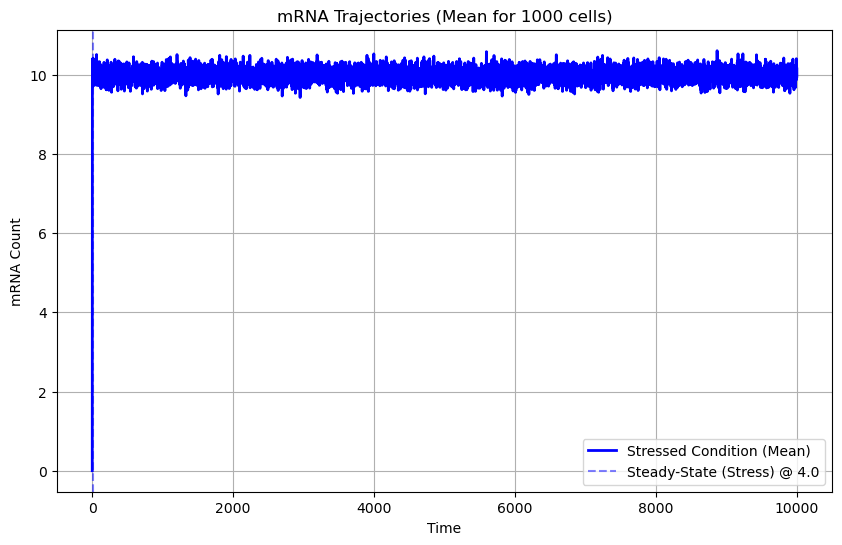

In [5]:
from visualisation.plots import plot_mRNA_trajectory
fig, ax = plot_mRNA_trajectory(parameter_sets, time_points, df_M)
# save the figure
# fig.savefig("test_telegraph_simulation_fixed_stats.png", dpi=300)

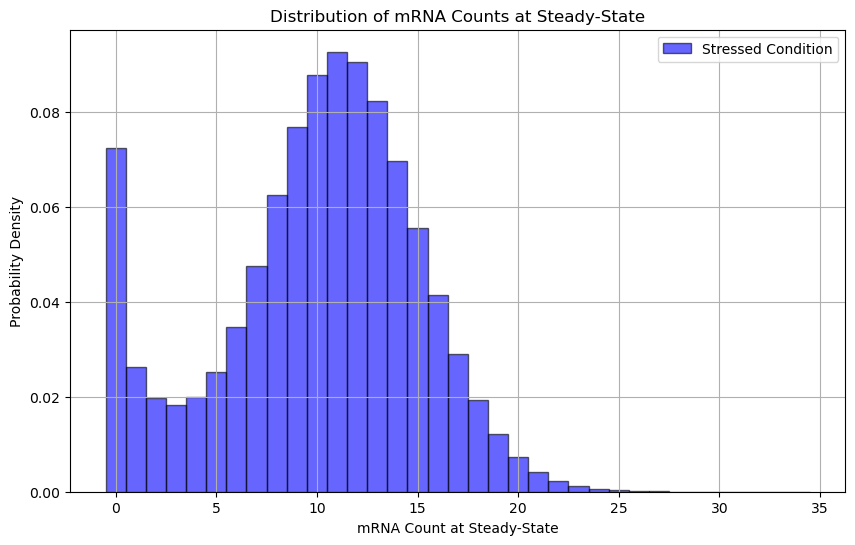

In [6]:
from visualisation.plots import plot_mRNA_dist
fig, ax = plot_mRNA_dist(parameter_sets, df_M, kde = False)

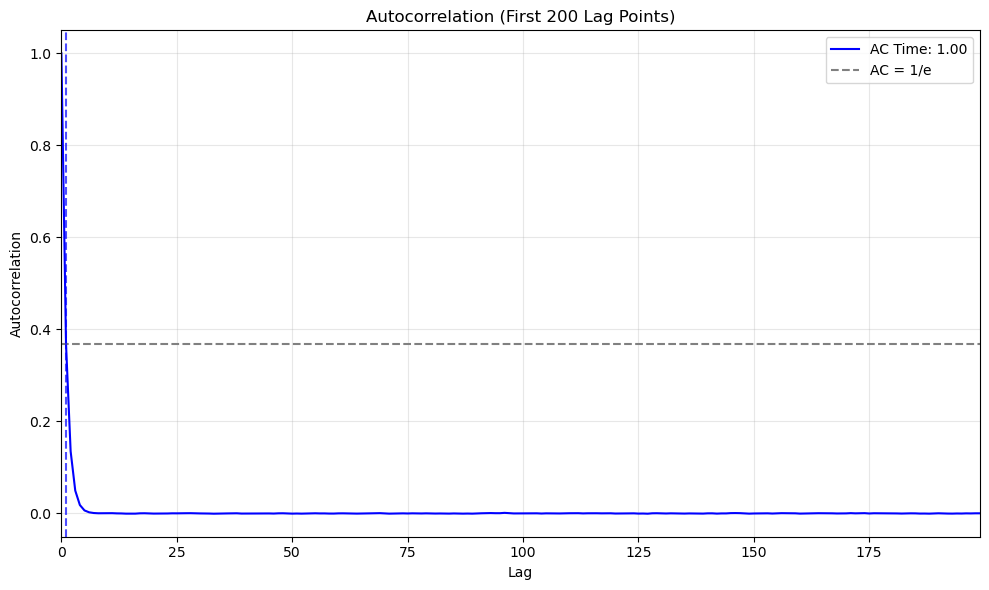

In [9]:
from stats.autocorrelation import calculate_autocorrelation, calculate_ac_time_interp1d
import matplotlib.pyplot as plt
import numpy as np

# Calculate autocorrelation for the sample dataset
df_ac = calculate_autocorrelation(df)

# Plot the autocorrelation for the sample
plt.figure(figsize=(10, 6))

# Calculate the mean autocorrelation ACROSS ALL TIME SERIES
mean_ac = np.nanmean(df_ac['stress_ac'], axis=0)
ac_time = calculate_ac_time_interp1d(mean_ac, df_ac['stress_lags'])

# Find indices for positive lags only (autocorrelation is symmetric)
# and limit to first 200 lag points
lags = df_ac['stress_lags']
positive_mask = lags >= 0
positive_lags = lags[positive_mask]
positive_mean_ac = mean_ac[positive_mask]

# Limit to first 200 points
max_lag_points = min(200, len(positive_lags))
plot_lags = positive_lags[:max_lag_points]
plot_ac = positive_mean_ac[:max_lag_points]

# Plot stress condition (zoomed in)
plt.plot(plot_lags, plot_ac, color='blue', label=f'AC Time: {ac_time:.2f}')

# Plot the AC time lines, show the values (only if within the plot range)
plt.axhline(y=1/np.e, color='gray', linestyle='--', label='AC = 1/e')
if ac_time <= plot_lags[-1]:  # Only show vertical line if it's within the plot range
    plt.axvline(x=ac_time, color='blue', linestyle='--', alpha=0.7)

plt.title('Autocorrelation (First 200 Lag Points)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, plot_lags[-1])  # Set x-axis limits explicitly
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()